In [32]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Load the data
df = pd.read_csv(r"C:\Users\abhij\Downloads\drive-download-20250725T092654Z-1-001\Auto_Insurance_Fraud_Claims_File01.csv")

# Convert Fraud_Ind to binary (1 for fraud, 0 for non-fraud)
df['Fraud'] = df['Fraud_Ind'].apply(lambda x: 1 if x == 'Y' else 0)

# Drop unnecessary columns
cols_to_drop = ['Claim_ID', 'Bind_Date1', 'Policy_Num', 'Fraud_Ind', 'Check_Point', 
                'Vehicle_Registration', 'DL_Expiry_Date', 'Claims_Date', 
                'Policy_Start_Date', 'Policy_Expiry_Date']
df = df.drop(cols_to_drop, axis=1)

# Separate features and target
X = df.drop('Fraud', axis=1)
y = df['Fraud']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [34]:
# Feature engineering function
def create_features(df):
    # Time-based features
    df['Vehicle_Age'] = 2024 - df['Auto_Year']  # Assuming current year is 2024
    
    # Claim ratios
    df['Injury_to_Total_Ratio'] = df['Injury_Claim'] / df['Total_Claim']
    df['Property_to_Total_Ratio'] = df['Property_Claim'] / df['Total_Claim']
    df['Vehicle_to_Total_Ratio'] = df['Vehicle_Claim'] / df['Total_Claim']
    
    # Policy duration (assuming accident date is close to claim date)
    # Would be better with actual dates, but we'll approximate
    
    # Flag for state mismatch
    df['State_Mismatch'] = (df['Policy_State'] != df['Acccident_State']).astype(int)
    
    # Fill infinite values and NaNs that might have been created
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(0, inplace=True)
    
    return df

# Apply feature engineering
X_train = create_features(X_train)
X_test = create_features(X_test)

In [36]:
# Identify numerical and categorical columns
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X_train.select_dtypes(include=['object']).columns

# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Bundle preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)])

In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Define model
# Ensure consistent data types
for col in X_train.columns:
    # If column has mixed types, convert all to string
    if X_train[col].apply(type).nunique() > 1:
        X_train[col] = X_train[col].astype(str)
        X_test[col] = X_test[col].astype(str)
    
    # Convert potential number columns stored as strings
    if X_train[col].dtype == 'object':
        try:
            X_train[col] = pd.to_numeric(X_train[col])
            X_test[col] = pd.to_numeric(X_test[col])
        except ValueError:
            pass  # Leave as string if conversion fails

# Re-define numerical and categorical columns
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X_train.select_dtypes(include=['object']).columns

# Print column types for verification
print("\nNumerical columns:", numerical_cols.tolist())
print("\nCategorical columns:", categorical_cols.tolist())

# Proceed with the pipeline definition as before...


Numerical columns: ['Customer_Life_Value1', 'Age_Insured', 'Policy_Ded', 'Policy_Premium', 'Umbrella_Limit', 'Insured_Zip', 'Capital_Gains', 'Capital_Loss', 'Accident_Hour', 'Num_of_Vehicles_Involved', 'Bodily_Injuries', 'Witnesses', 'Auto_Year', 'Vehicle_Cost', 'Annual_Mileage', 'DiffIN_Mileage', 'Low_Mileage_Discount', 'Commute_Discount', 'Total_Claim', 'Injury_Claim', 'Property_Claim', 'Vehicle_Claim', 'Vehicle_Age', 'Injury_to_Total_Ratio', 'Property_to_Total_Ratio', 'Vehicle_to_Total_Ratio']

Categorical columns: ['Policy_State', 'Policy_BI', 'Gender', 'Education', 'Occupation', 'Hobbies', 'Insured_Relationship', 'Garage_Location', 'Accident_Date', 'Accident_Type', 'Collision_Type', 'Accident_Severity', 'authorities_contacted', 'Acccident_State', 'Acccident_City', 'Accident_Location', 'Property_Damage', 'Police_Report', 'Auto_Make', 'Auto_Model', 'Vehicle_Color']


In [42]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

# Define numerical and categorical columns (from your output)
numerical_cols = ['Customer_Life_Value1', 'Age_Insured', 'Policy_Ded', 'Policy_Premium', 
                 'Umbrella_Limit', 'Insured_Zip', 'Capital_Gains', 'Capital_Loss', 
                 'Accident_Hour', 'Num_of_Vehicles_Involved', 'Bodily_Injuries', 
                 'Witnesses', 'Auto_Year', 'Vehicle_Cost', 'Annual_Mileage', 
                 'DiffIN_Mileage', 'Low_Mileage_Discount', 'Commute_Discount', 
                 'Total_Claim', 'Injury_Claim', 'Property_Claim', 'Vehicle_Claim', 
                 'Vehicle_Age', 'Injury_to_Total_Ratio', 'Property_to_Total_Ratio', 
                 'Vehicle_to_Total_Ratio']

categorical_cols = ['Policy_State', 'Policy_BI', 'Gender', 'Education', 'Occupation', 
                   'Hobbies', 'Insured_Relationship', 'Garage_Location', 'Accident_Date', 
                   'Accident_Type', 'Collision_Type', 'Accident_Severity', 
                   'authorities_contacted', 'Acccident_State', 'Acccident_City', 
                   'Accident_Location', 'Property_Damage', 'Police_Report', 'Auto_Make', 
                   'Auto_Model', 'Vehicle_Color']

# Numerical transformer - handles missing values and scaling
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Median imputation for robustness
    ('scaler', StandardScaler())                   # Standardize numerical features
])

# Categorical transformer - handles missing values and encoding
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Fill missing categories
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) # One-hot encode
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)],
    remainder='drop')  # Drop any columns not explicitly handled

# Example of how to use this in a full pipeline
from sklearn.ensemble import RandomForestClassifier

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=200,
        class_weight='balanced',
        random_state=42,
        max_depth=10,
        n_jobs=-1
    ))
])

In [44]:
df['Accident_Date'] = pd.to_datetime(df['Accident_Date'])
df['Accident_DayOfWeek'] = df['Accident_Date'].dt.dayofweek
df['Accident_Month'] = df['Accident_Date'].dt.month
# Then add these to numerical_cols and remove 'Accident_Date' from categorical_cols

In [46]:
from sklearn.feature_selection import SelectFromModel

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', SelectFromModel(
        RandomForestClassifier(n_estimators=100, random_state=42),
        threshold='median')),
    ('classifier', RandomForestClassifier())
])

In [50]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Define model
model = RandomForestClassifier(
    n_estimators=200,
    class_weight='balanced',
    random_state=42,
    max_depth=10,
    n_jobs=-1
)

# Create pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])

# Train model
pipeline.fit(X_train, y_train)

# Predictions
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.90      0.94      6024
           1       0.76      0.98      0.86      1976

    accuracy                           0.92      8000
   macro avg       0.88      0.94      0.90      8000
weighted avg       0.94      0.92      0.92      8000


Confusion Matrix:
[[5414  610]
 [  31 1945]]

ROC AUC Score: 0.994927173895511


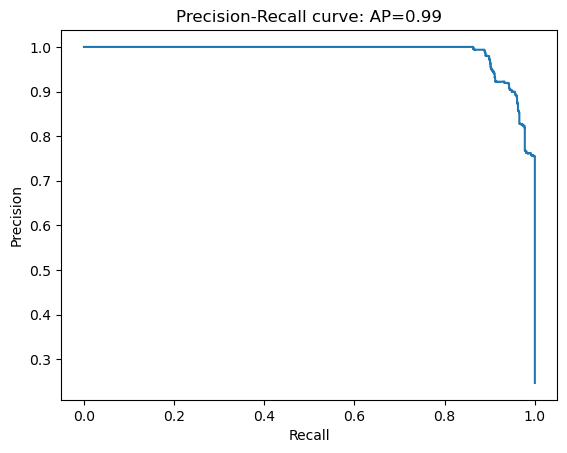

In [52]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# ROC AUC
print("\nROC AUC Score:", roc_auc_score(y_test, y_proba))

# Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_proba)
average_precision = average_precision_score(y_test, y_proba)

plt.figure()
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
plt.show()

In [54]:
# Get feature names after one-hot encoding
onehot_columns = pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_cols)
all_features = np.concatenate([numerical_cols, onehot_columns])

# Get feature importances
importances = pipeline.named_steps['model'].feature_importances_
indices = np.argsort(importances)[::-1]

# Print top 20 features
print("\nTop 20 Important Features:")
for f in range(20):
    print(f"{f+1}. {all_features[indices[f]]}: {importances[indices[f]]}")


Top 20 Important Features:
1. Accident_Severity_Major Damage: 0.14384955264603067
2. Accident_Severity_Minor Damage: 0.05665380701715783
3. Hobbies_chess: 0.051615222095888855
4. Accident_Severity_Total Loss: 0.039369273425141744
5. Hobbies_cross-fit: 0.02599835159215615
6. Collision_Type_Unknown: 0.024628837554977263
7. Insured_Zip: 0.02079364953298668
8. Accident_Severity_Trivial Damage: 0.019291466710592987
9. Policy_Premium: 0.018692813374333768
10. Accident_Type_Vehicle Theft: 0.017025932478501166
11. authorities_contacted_0: 0.014972497562935696
12. Accident_Hour: 0.014897953376229497
13. Vehicle_Cost: 0.014271562446284976
14. Age_Insured: 0.013259907904947164
15. Auto_Year: 0.011646298664205836
16. Capital_Gains: 0.011315788067612067
17. Witnesses: 0.010452792492104459
18. Vehicle_Age: 0.010428408923526495
19. Capital_Loss: 0.009442886619366202
20. Hobbies_camping: 0.008686011062153694


In [56]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Redefine pipeline with SMOTE
model_smote = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    max_depth=10,
    n_jobs=-1
)

pipeline_smote = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('model', model_smote)
])

pipeline_smote.fit(X_train, y_train)
y_pred_smote = pipeline_smote.predict(X_test)

print("\nClassification Report with SMOTE:")
print(classification_report(y_test, y_pred_smote))


Classification Report with SMOTE:
              precision    recall  f1-score   support

           0       0.99      0.90      0.94      6024
           1       0.76      0.97      0.85      1976

    accuracy                           0.92      8000
   macro avg       0.87      0.93      0.90      8000
weighted avg       0.93      0.92      0.92      8000



In [58]:
import joblib

# Save the model
joblib.dump(pipeline, 'insurance_fraud_model.pkl')

# Example of loading and using the model
# loaded_model = joblib.load('insurance_fraud_model.pkl')
# new_predictions = loaded_model.predict(new_data)

['insurance_fraud_model.pkl']

In [60]:
import streamlit as st
import pandas as pd
import joblib

# Load your trained model
model = joblib.load('insurance_fraud_model.pkl')

st.title("Insurance Fraud Detection System")

# Input form
with st.form("claim_form"):
    st.header("Claim Details")
    
    # Numerical inputs
    total_claim = st.number_input("Total Claim Amount ($)", min_value=0)
    vehicle_cost = st.number_input("Vehicle Value ($)", min_value=0)
    injury_claim = st.number_input("Injury Claim Amount ($)", min_value=0)
    
    # Categorical inputs
    accident_type = st.selectbox("Accident Type", 
                               ["Collision", "Theft", "Other"])
    policy_state = st.selectbox("Policy State", 
                              ["CA", "NY", "TX", "FL", "OH"])
    accident_state = st.selectbox("Accident State", 
                                ["CA", "NY", "TX", "FL", "OH"])
    
    # Date inputs
    policy_start = st.date_input("Policy Start Date")
    accident_date = st.date_input("Accident Date")
    
    submitted = st.form_submit_button("Check for Fraud")

if submitted:
    # Prepare input data
    input_data = pd.DataFrame({
        'Total_Claim': [total_claim],
        'Vehicle_Cost': [vehicle_cost],
        'Injury_Claim': [injury_claim],
        'Accident_Type': [accident_type],
        'Policy_State': [policy_state],
        'Acccident_State': [accident_state],
        'Days_Since_Policy_Start': [(accident_date - policy_start).days],
        'Claim_to_VehicleValue_Ratio': [total_claim / vehicle_cost if vehicle_cost > 0 else 0]
    })
    
    # Make prediction
    fraud_prob = model.predict_proba(input_data)[0][1]
    is_fraud = fraud_prob > 0.5  # Or use your optimal threshold
    
    # Display results
    st.subheader("Results")
    st.metric("Fraud Probability", f"{fraud_prob:.1%}")
    
    if is_fraud:
        st.error("🚨 High fraud risk detected!")
        st.write("Recommended actions: Manual review required")
    else:
        st.success("✅ Low fraud risk")
        st.write("Recommended actions: Standard processing")
    
    # Show explanation
    st.subheader("Key Factors")
    st.write("Top contributing factors to this prediction:")
    # Add code to display feature importance for this specific prediction

2025-07-25 16:27:23.413 
  command:

    streamlit run C:\Users\abhij\anaconda3\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-07-25 16:27:23.413 Session state does not function when running a script without `streamlit run`


In [62]:
streamlit run C:\Users\abhij\anaconda3\Lib\site-packages\ipykernel_launcher.py

SyntaxError: invalid syntax (1641950924.py, line 1)